<a href="https://colab.research.google.com/github/dinianggraini13/SKRIPSI/blob/main/CNN(berhasil).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Machine Learning Libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns
import nltk
from nltk import word_tokenize, WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import spacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pickle

import os
import collections

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Deep Learning Libraries

#For Word2Vec Embedding
from gensim import models
import gensim
from gensim.models import Word2Vec

#For Building Model
import tensorflow as tf
import keras
from keras import regularizers, backend as K
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, MaxPooling1D, Embedding, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model

In [ ]:
!pip install mlxtend

In [ ]:
from mlxtend.plotting import plot_confusion_matrix

LOAD DATASET

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('hasilreviews_label.csv')

# Membuat DataFrame 'hasilreviews_label' dari data yang diunggah
hasilreviews_label = pd.DataFrame(data, columns=['content', 'label'])

# Cetak beberapa baris pertama dari DataFrame 'hasilreviews_label' untuk memeriksa hasilnya
print(hasilreviews_label.head())


                                             content  label
0  I literally can't use the app. It won't let me...      0
1  The platform has potential, but the app, which...      1
2  Pretty good for a first launch!! Its easy to u...      1
3  Currently, it's very challenging to use. It's ...      0
4  Meh. Not the greatest experience on a Chromebo...      0


In [ ]:
data['label'].value_counts()

0    15703
2    14758
1     3008
Name: label, dtype: int64

PREPROCESSING

In [ ]:
# Memuat model bahasa spaCy (ganti 'en_core_web_sm' dengan model yang sesuai)
nlp = spacy.load('en_core_web_sm')

# Fungsi untuk tokenization, stopword removal, dan stemming
def preprocess_text(text):
    # Menghapus tanda baca
    translator = str.maketrans('', '', string.punctuation)
    text_no_punct = text.translate(translator)

    # Menghapus karakter non-ASCII (emotikon umumnya non-ASCII)
    text_no_emoticons = re.sub(r'[^\x00-\x7F]+', ' ', text_no_punct)

    # Tokenization
    tokens = word_tokenize(text_no_emoticons.lower())

    # Stopword removal using spaCy
    doc = nlp(" ".join(tokens))
    filtered_tokens = [token.text for token in doc if not token.is_stop]

    # Stemming
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]

    return ' '.join(stemmed_tokens)

# Muat data Anda dan bersihkan teks
data = pd.read_csv("hasilreviews_label.csv")

# Tambahkan kolom untuk hasil preprocessing
data['cleaned_content'] = data['content'].apply(preprocess_text)

# Fungsi untuk tokenisasi dan penghapusan stopwords
def tokenize(text):
    doc = nlp(text)
    return [token.text for token in doc if not token.is_stop]

# Tambahkan kolom 'tokenized_content'
data['tokenized_content'] = data['cleaned_content'].apply(tokenize)

# Tampilkan dataframe data sebelum dan sesudah preprocessing
print("Data Sebelum Preprocessing:")
print(data[['content']])

print("\nData Sesudah Preprocessing:")
print(data[['cleaned_content', 'tokenized_content']])

Data Sebelum Preprocessing:
                                                 content
0      I literally can't use the app. It won't let me...
1      The platform has potential, but the app, which...
2      Pretty good for a first launch!! Its easy to u...
3      Currently, it's very challenging to use. It's ...
4      Meh. Not the greatest experience on a Chromebo...
...                                                  ...
33464             Twitter is better then this copied app
33465                                         Cheap copy
33466  App some Designs copied from Twitter ... I thi...
33467                                                 Ok
33468                  T don't like very so the nice 👍🏻❤

[33469 rows x 1 columns]

Data Sesudah Preprocessing:
                                         cleaned_content  \
0      liter nt use app wo nt let search post look no...   
1      platform potenti app main way use platform mom...   
2      pretti good launch easi use selfexplanatori d 

SPLIT DATA

In [ ]:
# Memisahkan data menjadi data sementara (temp_data) dan data pengujian
temp_data, data_test = train_test_split(data, test_size=0.2, random_state=42)

# Memisahkan data sementara menjadi data pelatihan dan data validasi
data_train, data_val = train_test_split(temp_data, test_size=0.25, random_state=42)

print("Data train: %s, Data val: %s, Data test: %s." % (data_train.shape[0], data_val.shape[0], data_test.shape[0]))

Data train: 20081, Data val: 6694, Data test: 6694.


Check Vocab Size and max sentence lenght

In [ ]:
#data train
all_training_words = [word for tokens in data_train["tokenized_content"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokenized_content"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))

print("Data train total words : %s , Vocabulary size : %s" % (len(all_training_words), len(TRAINING_VOCAB)))

Data train total words : 139600 , Vocabulary size : 8893


In [ ]:
#data val
all_validation_words = [word for tokens in data_val["tokenized_content"] for word in tokens]
validation_sentence_lengths = [len(tokens) for tokens in data_val["tokenized_content"]]
VALIDATION_VOCAB = sorted(list(set(all_validation_words)))

print("Data validation total words: %s, Vocabulary size: %s" % (len(all_validation_words), len(VALIDATION_VOCAB)))


Data validation total words: 46967, Vocabulary size: 4969


In [ ]:
#data test
all_test_words = [word for tokens in data_test["tokenized_content"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokenized_content"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("Data test total words : %s , Vocabulary size : %s" % (len(all_test_words), len(TEST_VOCAB)))

Data test total words : 46385 , Vocabulary size : 4882


# Word Embeddings

In [ ]:
from gensim.models import Word2Vec

# Membangun model Word2Vec
model = Word2Vec(data['tokenized_content'], vector_size=100, window=5, min_count=1, sg=0)

# Simpan model Word2Vec
model.save("word2vec_model.model")

In [ ]:
vector = model.wv['use']
print(vector)

[-3.86935234e-01  2.78561711e-01  1.05668819e+00 -1.39745817e-01
 -6.60482496e-02 -2.89920807e-01  4.19515312e-01  1.75766349e+00
  5.86693510e-02 -5.13989627e-01 -2.15449765e-01 -1.11807418e+00
 -5.40680468e-01 -3.15978974e-01 -1.02894813e-01 -2.58837610e-01
  6.31094947e-02 -5.24506211e-01 -2.58589908e-02 -1.42746294e+00
  2.58031860e-02  9.69607294e-01  4.32099074e-01 -1.26015067e-01
 -5.36389470e-01  9.21284795e-01 -5.72698116e-01 -9.61378336e-01
 -4.47322458e-01  3.46141726e-01  2.61187136e-01  3.12524170e-01
 -2.81340152e-01 -9.13148284e-01 -5.76559007e-01  1.17889249e+00
 -6.39821291e-01 -9.83062804e-01 -2.63202786e-01 -7.70019770e-01
  6.02437258e-01 -3.14114690e-01 -1.01407230e-01 -3.62868071e-01
  4.12359029e-01 -3.51366580e-01 -5.34758568e-01 -8.84493142e-02
 -1.71748381e-02 -2.71555573e-01  4.98762995e-01 -4.12348509e-01
  3.65637869e-01  1.49168283e-01 -1.47770807e-01  4.58759695e-01
  2.19515394e-02  6.74316764e-01 -5.05751789e-01  2.34771192e-01
 -3.09667349e-01 -1.96897

In [ ]:
similar_words = model.wv.most_similar(positive=[vector], topn=1)
print(similar_words)


[('use', 1.0000001192092896)]


In [ ]:
#max sequence length
data_train['doc_len'] = data_train['content'].apply(lambda words: len(words.split(' ')))
max_seq_len = np.max(data_train['doc_len'])+1


In [ ]:
max_seq_len

108

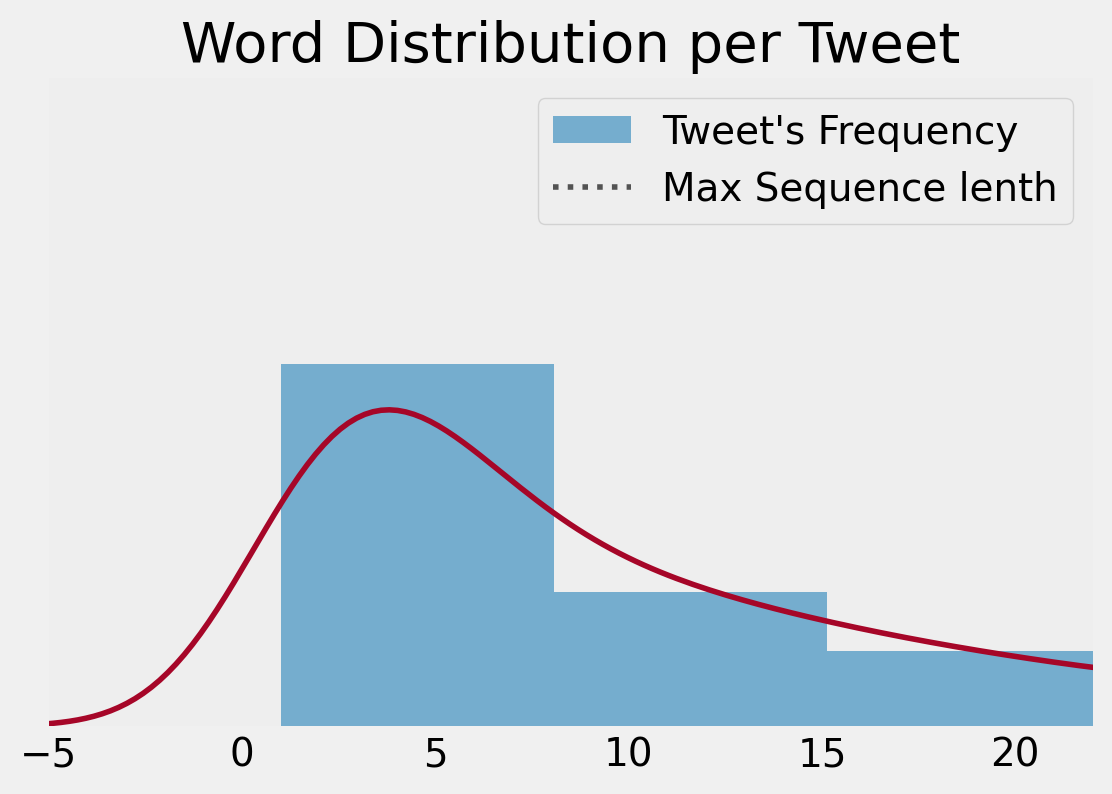

In [ ]:
#Plot
fig, ax = plt.subplots(figsize=(6,4))

data_train['doc_len'].plot(kind='hist',
                      density=True,
                      alpha=0.65,
                      bins=15,
                      label="Tweet's Frequency")

data_train['doc_len'].plot(kind='kde', label='')

ax.set_xlim(-5, 22)
ax.set_xlabel("")
ax.set_ylim(0, 0.13)
ax.set_yticks([])
ax.set_ylabel("")
ax.set_title("Word Distribution per Tweet")
ax.grid(False)
ax.axvline(x=max_seq_len, alpha=0.65, color='k', linestyle=':', label='Max Sequence lenth')
ax.tick_params(left = False, bottom = False)
for ax, spine in ax.spines.items():
    spine.set_visible(False)

plt.legend()
plt.show()

Tokenize and Pad sequences

In [26]:
raw_docs_train = data_train['content'].tolist()
raw_docs_val = data_val['content'].tolist()
raw_docs_test = data_test['content'].tolist()

In [27]:
# Tokenizing input data for training
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(raw_docs_train)
word_seq_train = tokenizer.texts_to_sequences(raw_docs_train)
word_seq_test = tokenizer.texts_to_sequences(raw_docs_test)
word_seq_val = tokenizer.texts_to_sequences(raw_docs_val)

word_index = tokenizer.word_index
print('Dictionary Size: ', len(word_index))


Dictionary Size:  13764


In [28]:
# Tentukan panjang maksimum urutan kata yang sesuai berdasarkan data
max_seq_len = 100  # Contoh: Anda dapat mengatur panjang maksimum menjadi 100

# Lakukan padding pada urutan kata untuk data pelatihan
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)

# Lakukan padding pada urutan kata untuk data validasi
word_seq_val = sequence.pad_sequences(word_seq_val, maxlen=max_seq_len)

# Lakukan padding pada urutan kata untuk data pengujian
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)


In [31]:
len(word_seq_test)

6694

Train Embeddings Weights

In [37]:
#dimension
EMBEDDING_DIM = 100

In [38]:
train_embedding_weights = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

for word, index in word_index.items():
    if word in model.wv:
        train_embedding_weights[index, :] = model.wv[word]
    else:
        train_embedding_weights[index, :] = np.random.rand(EMBEDDING_DIM)

print(train_embedding_weights.shape)


(13765, 100)


# Hyperparameter CNN

In [39]:
lr = 0.01
batch_size  = 32
num_epochs  = 10
num_filters = 128
filter_size = 2

In [40]:
nb_words = len(word_index)
nb_words

13764

In [49]:
# Kolom label yang berisi nilai 0, 1, 2
train_labels = to_categorical(data_train['label'], num_classes=3)
val_labels = to_categorical(data_val['label'], num_classes=3)
test_labels = to_categorical(data_test['label'], num_classes=3)

In [47]:
train_labels = one_hot_labels

In [42]:
#early stopping for avoid overfitting model
#early_stopping = EarlyStopping(monitor='val_loss',
                               #min_delta=0.01,
                               #patience=3,
                               #verbose=1)

#callbacks_list = [early_stopping]

# Building Model CNN

In [43]:
model = Sequential(name='model')

model.add(Embedding(nb_words+1, EMBEDDING_DIM,
                    weights=[train_embedding_weights],
                    input_length=max_seq_len,
                    trainable=False))

model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))


model.add(Conv1D(num_filters, filter_size, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(GlobalMaxPooling1D())


model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)))
model.add(Dense(num_classes, activation='softmax'))


adam = tf.optimizers.Adam(lr)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1376500   
                                                                 
 conv1d (Conv1D)             (None, 100, 128)          25728     
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 128)           32896     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 25, 128)           0         
 g1D)                                                        

In [51]:
# Pelatihan model
hist = model.fit(word_seq_train,
                 train_labels,
                 batch_size=batch_size,
                 epochs=num_epochs,
                 validation_data=(word_seq_val, val_labels),  # Gunakan data validasi yang sesungguhnya
                 callbacks=callbacks_list,
                 shuffle=True,
                 verbose=2)

# Evaluasi model pada data pelatihan
train_loss, train_accuracy = model.evaluate(word_seq_train, train_labels, verbose=0)
train_predictions = model.predict(word_seq_train)
train_predictions = np.argmax(train_predictions, axis=1)
train_true_labels = np.argmax(train_labels, axis=1)
train_confusion = confusion_matrix(train_true_labels, train_predictions)

# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(word_seq_val, val_labels, verbose=0)
val_predictions = model.predict(word_seq_val)
val_predictions = np.argmax(val_predictions, axis=1)
val_true_labels = np.argmax(val_labels, axis=1)
val_confusion = confusion_matrix(val_true_labels, val_predictions)

# Evaluasi model pada data pengujian
test_loss, test_accuracy = model.evaluate(word_seq_test, test_labels, verbose=0)
test_predictions = model.predict(word_seq_test)
test_predictions = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(test_labels, axis=1)
test_confusion = confusion_matrix(test_true_labels, test_predictions)

# Menampilkan hasil
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Train Confusion Matrix:")
print(train_confusion)
print("Classification Report (Train):")
print(classification_report(train_true_labels, train_predictions))

print("Validation Loss:", val_loss)
print("Validation Accuracy:", val_accuracy)
print("Validation Confusion Matrix:")
print(val_confusion)
print("Classification Report (Validation):")
print(classification_report(val_true_labels, val_predictions))

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Confusion Matrix:")
print(test_confusion)
print("Classification Report (Test):")
print(classification_report(test_true_labels, test_predictions))


Epoch 1/10
628/628 - 23s - loss: 0.6045 - accuracy: 0.7603 - val_loss: 0.6301 - val_accuracy: 0.7755 - 23s/epoch - 37ms/step
Epoch 2/10
628/628 - 15s - loss: 0.6015 - accuracy: 0.7606 - val_loss: 0.6121 - val_accuracy: 0.7743 - 15s/epoch - 25ms/step
Epoch 3/10
628/628 - 16s - loss: 0.5942 - accuracy: 0.7671 - val_loss: 0.6499 - val_accuracy: 0.7776 - 16s/epoch - 25ms/step
Epoch 4/10
628/628 - 16s - loss: 0.5934 - accuracy: 0.7669 - val_loss: 0.6319 - val_accuracy: 0.7791 - 16s/epoch - 25ms/step
Epoch 5/10
628/628 - 17s - loss: 0.5875 - accuracy: 0.7679 - val_loss: 0.6403 - val_accuracy: 0.7838 - 17s/epoch - 28ms/step
Epoch 5: early stopping
210/210 [==============================] - 1s 7ms/step
Train Loss: 0.6207780838012695
Train Accuracy: 0.7917932271957397
Train Confusion Matrix:
[[8212    9 1169]
 [ 921   24  901]
 [1177    4 7664]]
Classification Report (Train):
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      9390
           

In [54]:
from keras.callbacks import Callback
import numpy as np

class EvaluateOnEpochEnd(Callback):
    def __init__(self, model, word_seq_train, train_labels, word_seq_val, val_labels, word_seq_test, test_labels):
        self.model = model
        self.word_seq_train = word_seq_train
        self.train_labels = train_labels
        self.word_seq_val = word_seq_val
        self.val_labels = val_labels
        self.word_seq_test = word_seq_test
        self.test_labels = test_labels

    def on_epoch_end(self, epoch, logs=None):
        # Evaluasi model pada data pelatihan
        train_loss, train_accuracy = self.model.evaluate(self.word_seq_train, self.train_labels, verbose=0)
        train_predictions = self.model.predict(self.word_seq_train)
        train_predictions = np.argmax(train_predictions, axis=1)
        train_true_labels = np.argmax(self.train_labels, axis=1)

        # Evaluasi model pada data validasi
        val_loss, val_accuracy = self.model.evaluate(self.word_seq_val, self.val_labels, verbose=0)
        val_predictions = self.model.predict(self.word_seq_val)
        val_predictions = np.argmax(val_predictions, axis=1)
        val_true_labels = np.argmax(self.val_labels, axis=1)

        # Evaluasi model pada data pengujian
        test_loss, test_accuracy = self.model.evaluate(self.word_seq_test, self.test_labels, verbose=0)
        test_predictions = self.model.predict(self.word_seq_test)
        test_predictions = np.argmax(test_predictions, axis=1)
        test_true_labels = np.argmax(self.test_labels, axis=1)

        print(f'Epoch {epoch}')
        print(f'Training loss: {train_loss}')
        print(f'Validation loss: {val_loss}')
        print(f'F1 Score: {f1_score(train_true_labels, train_predictions, average="weighted")}')
        print(f'Precision Score: {precision_score(train_true_labels, train_predictions, average="weighted")}')
        print(f'Recall Score: {recall_score(train_true_labels, train_predictions, average="weighted")}')
        print(f'Accuracy Score: {accuracy_score(train_true_labels, train_predictions)}')
        print(f'Test loss: {test_loss}')
        print(f'Test F1 Score: {f1_score(test_true_labels, test_predictions, average="weighted")}')
        print(f'Test Precision Score: {precision_score(test_true_labels, test_predictions, average="weighted")}')
        print(f'Test Recall Score: {recall_score(test_true_labels, test_predictions, average="weighted")}')
        print(f'Test Accuracy Score: {accuracy_score(test_true_labels, test_predictions)}')

# Callback untuk evaluasi
evaluate_callback = EvaluateOnEpochEnd(model, word_seq_train, train_labels, word_seq_val, val_labels, word_seq_test, test_labels)

# Pelatihan model tanpa early stopping
hist = model.fit(word_seq_train,
                 train_labels,
                 batch_size=batch_size,
                 epochs=num_epochs,
                 validation_data=(word_seq_val, val_labels),  # Gunakan data validasi yang sesungguhnya
                 callbacks=[evaluate_callback],  # Hapus callback EarlyStopping
                 shuffle=True,
                 verbose=2)


Epoch 1/10
210/210 [==============================] - 1s 7ms/step
Epoch 0
Training loss: 0.5758686065673828
Validation loss: 0.6145647764205933
F1 Score: 0.7842706973695119
Precision Score: 0.7991122347298988
Recall Score: 0.8151486479756984
Accuracy Score: 0.8151486479756984
Test loss: 0.6035389304161072
Test F1 Score: 0.7648215443713553
Test Precision Score: 0.7669758532113254
Test Recall Score: 0.7956378846728414
Test Accuracy Score: 0.7956378846728414
628/628 - 41s - loss: 0.5513 - accuracy: 0.7870 - val_loss: 0.6146 - val_accuracy: 0.7916 - 41s/epoch - 66ms/step
Epoch 2/10
210/210 [==============================] - 1s 7ms/step
Epoch 1
Training loss: 0.554152250289917
Validation loss: 0.5948716998100281
F1 Score: 0.776307500278463
Precision Score: 0.8022168311031085
Recall Score: 0.8128081270853045
Accuracy Score: 0.8128081270853045
Test loss: 0.5868018269538879
Test F1 Score: 0.7577521502329128
Test Precision Score: 0.7613984239576689
Test Recall Score: 0.7922019719151479
Test Acc

In [55]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
import numpy as np

# Callback untuk evaluasi
evaluate_callback = EvaluateOnEpochEnd(model, word_seq_train, train_labels, word_seq_val, val_labels, word_seq_test, test_labels)

# Pelatihan model
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    hist = model.fit(word_seq_train,
                     train_labels,
                     batch_size=batch_size,
                     epochs=1,  # Pelatihan hanya 1 epoch
                     validation_data=(word_seq_val, val_labels),  # Gunakan data validasi yang sesungguhnya
                     shuffle=True,
                     verbose=2)

    # Evaluasi model pada data pelatihan
    evaluate_callback.on_epoch_end(epoch, logs=None)

# Setelah pelatihan selesai, hitung rata-rata metrik evaluasi dan loss pada data pelatihan
final_train_loss, final_train_accuracy = model.evaluate(word_seq_train, train_labels, verbose=0)
final_train_predictions = model.predict(word_seq_train)
final_train_predictions = np.argmax(final_train_predictions, axis=1)
final_train_true_labels = np.argmax(train_labels, axis=1)

final_train_f1 = f1_score(final_train_true_labels, final_train_predictions, average="weighted")
final_train_precision = precision_score(final_train_true_labels, final_train_predictions, average="weighted")
final_train_recall = recall_score(final_train_true_labels, final_train_predictions, average="weighted")
final_train_accuracy_score = accuracy_score(final_train_true_labels, final_train_predictions)

# Hitung rata-rata metrik evaluasi dan loss pada data validasi
final_val_loss, final_val_accuracy = model.evaluate(word_seq_val, val_labels, verbose=0)
final_val_predictions = model.predict(word_seq_val)
final_val_predictions = np.argmax(final_val_predictions, axis=1)
final_val_true_labels = np.argmax(val_labels, axis=1)

final_val_f1 = f1_score(final_val_true_labels, final_val_predictions, average="weighted")
final_val_precision = precision_score(final_val_true_labels, final_val_predictions, average="weighted")
final_val_recall = recall_score(final_val_true_labels, final_val_predictions, average="weighted")
final_val_accuracy_score = accuracy_score(final_val_true_labels, final_val_predictions)

# Hitung rata-rata metrik evaluasi dan loss pada data pengujian
final_test_loss, final_test_accuracy = model.evaluate(word_seq_test, test_labels, verbose=0)
final_test_predictions = model.predict(word_seq_test)
final_test_predictions = np.argmax(final_test_predictions, axis=1)
final_test_true_labels = np.argmax(test_labels, axis=1)

final_test_f1 = f1_score(final_test_true_labels, final_test_predictions, average="weighted")
final_test_precision = precision_score(final_test_true_labels, final_test_predictions, average="weighted")
final_test_recall = recall_score(final_test_true_labels, final_test_predictions, average="weighted")
final_test_accuracy_score = accuracy_score(final_test_true_labels, final_test_predictions)

# Tampilkan hasil akhir
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy_score)
print("Final Training F1 Score:", final_train_f1)
print("Final Training Precision Score:", final_train_precision)
print("Final Training Recall Score:", final_train_recall)

print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy_score)
print("Final Validation F1 Score:", final_val_f1)
print("Final Validation Precision Score:", final_val_precision)
print("Final Validation Recall Score:", final_val_recall)

print("Final Test Loss:", final_test_loss)
print("Final Test Accuracy:", final_test_accuracy_score)
print("Final Test F1 Score:", final_test_f1)
print("Final Test Precision Score:", final_test_precision)
print("Final Test Recall Score:", final_test_recall)


Epoch 1/10
628/628 - 20s - loss: 0.5318 - accuracy: 0.7945 - val_loss: 0.5683 - val_accuracy: 0.7941 - 20s/epoch - 32ms/step
210/210 [==============================] - 1s 7ms/step
Epoch 0
Training loss: 0.5174742341041565
Validation loss: 0.568312406539917
F1 Score: 0.782386388715652
Precision Score: 0.8070349789821095
Recall Score: 0.8207260594591903
Accuracy Score: 0.8207260594591903
Test loss: 0.5625903606414795
Test F1 Score: 0.7615080925785819
Test Precision Score: 0.7715989248212674
Test Recall Score: 0.7974305348072901
Test Accuracy Score: 0.7974305348072901
Epoch 2/10
628/628 - 16s - loss: 0.5334 - accuracy: 0.7965 - val_loss: 0.5918 - val_accuracy: 0.7965 - 16s/epoch - 25ms/step
210/210 [==============================] - 1s 6ms/step
Epoch 1
Training loss: 0.5415173768997192
Validation loss: 0.5917779207229614
F1 Score: 0.7851729390866635
Precision Score: 0.8142923409757823
Recall Score: 0.8200288830237538
Accuracy Score: 0.8200288830237538
Test loss: 0.5835934281349182
Test F1

ValueError: ignored

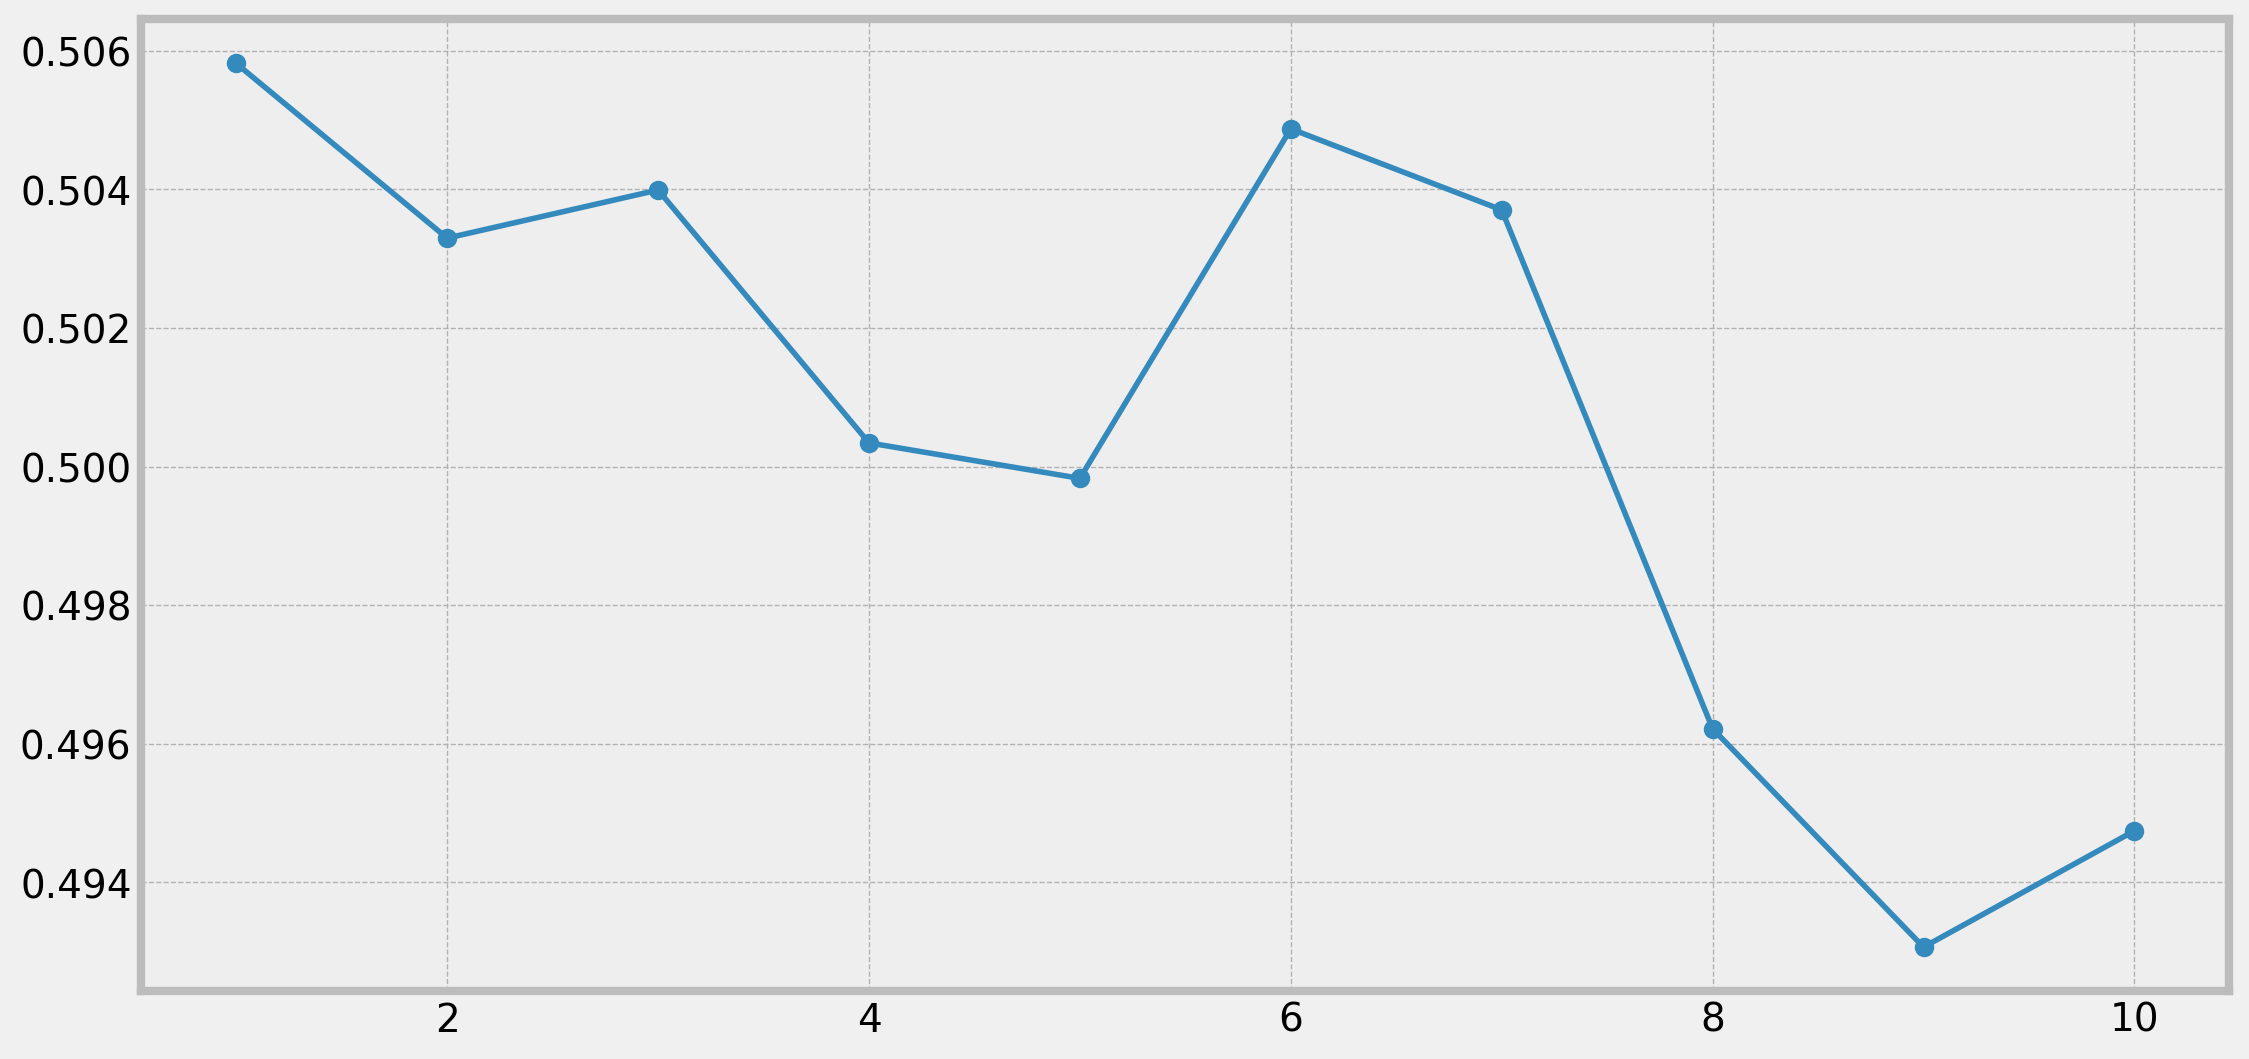

In [64]:
import matplotlib.pyplot as plt

# Menggunakan range(1, num_epochs + 1) untuk sumbu x
epochs = range(1, num_epochs + 1)

# Plot training loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_f1_scores, label='Validation F1 Score', marker='o')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o')
plt.title('Validation and Test F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_precision_scores, label='Validation Precision Score', marker='o')
plt.plot(epochs, test_precision_scores, label='Test Precision Score', marker='o')
plt.title('Validation and Test Precision Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_recall_scores, label='Validation Recall Score', marker='o')
plt.plot(epochs, test_recall_scores, label='Test Recall Score', marker='o')
plt.title('Validation and Test Recall Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Score
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracy_scores, label='Validation Accuracy Score', marker='o')
plt.plot(epochs, test_accuracy_scores, label='Test Accuracy Score', marker='o')
plt.title('Validation and Test Accuracy Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
# Callback untuk evaluasi
evaluate_callback = EvaluateOnEpochEnd(model, word_seq_train, train_labels, word_seq_val, val_labels, word_seq_test, test_labels)

# Lists to store metrics
train_losses = []
val_losses = []
test_losses = []
val_metrics = {'f1': [], 'precision': [], 'recall': [], 'accuracy': []}
test_metrics = {'f1': [], 'precision': [], 'recall': [], 'accuracy': []}

# Training model
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    hist = model.fit(word_seq_train,
                     train_labels,
                     batch_size=batch_size,
                     epochs=1,
                     validation_data=(word_seq_val, val_labels),
                     shuffle=True,
                     verbose=2)

    train_losses.append(hist.history['loss'][0])

    # Evaluate model on training, validation, and test data
    evaluate_callback.on_epoch_end(epoch, logs=None)

# Calculate average metrics and losses
final_train_loss = np.mean(train_losses)
final_val_loss = np.mean(val_losses)
final_test_loss = np.mean(test_losses)

final_val_f1 = np.mean(val_metrics['f1'])
final_val_precision = np.mean(val_metrics['precision'])
final_val_recall = np.mean(val_metrics['recall'])
final_val_accuracy_score = np.mean(val_metrics['accuracy'])

final_test_f1 = np.mean(test_metrics['f1'])
final_test_precision = np.mean(test_metrics['precision'])
final_test_recall = np.mean(test_metrics['recall'])
final_test_accuracy_score = np.mean(test_metrics['accuracy'])

# Display final metrics
print("Final Training Loss:", final_train_loss)
print("Final Validation Loss:", final_val_loss)
print("Final Validation F1 Score:", final_val_f1)
print("Final Validation Precision Score:", final_val_precision)
print("Final Validation Recall Score:", final_val_recall)
print("Final Validation Accuracy Score:", final_val_accuracy_score)

print("Final Test Loss:", final_test_loss)
print("Final Test F1 Score:", final_test_f1)
print("Final Test Precision Score:", final_test_precision)
print("Final Test Recall Score:", final_test_recall)
print("Final Test Accuracy Score:", final_test_accuracy_score)


Epoch 1/10
628/628 - 17s - loss: 0.5058 - accuracy: 0.8056 - val_loss: 0.5665 - val_accuracy: 0.8021 - 17s/epoch - 28ms/step
210/210 [==============================] - 1s 7ms/step
Epoch 0
Training loss: 0.5004442930221558
Validation loss: 0.5664994716644287
F1 Score: 0.772127971177873
Precision Score: 0.7867840125834654
Recall Score: 0.8020615476546161
Accuracy Score: 0.8020615476546161
Test loss: 0.561160147190094
Test F1 Score: 0.7675928594270149
Test Precision Score: 0.7823267720156245
Test Recall Score: 0.7984762473857185
Test Accuracy Score: 0.7984762473857185
Epoch 2/10
628/628 - 16s - loss: 0.5033 - accuracy: 0.8064 - val_loss: 0.5825 - val_accuracy: 0.7992 - 16s/epoch - 25ms/step
210/210 [==============================] - 1s 7ms/step
Epoch 1
Training loss: 0.5176615118980408
Validation loss: 0.5824871063232422
F1 Score: 0.773961116308818
Precision Score: 0.7759758587775115
Recall Score: 0.7992231849417388
Accuracy Score: 0.7992231849417388
Test loss: 0.5760430693626404
Test F1 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [73]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score, accuracy_score
import numpy as np

# Callback untuk evaluasi
evaluate_callback = EvaluateOnEpochEnd(model, word_seq_train, train_labels, word_seq_val, val_labels, word_seq_test, test_labels)

# Inisialisasi list untuk menyimpan metrik-metrik
train_losses = []
val_losses = []
test_losses = []  # Tambahkan list untuk loss pada data tes
train_f1_scores = []
val_f1_scores = []
test_f1_scores = []  # Tambahkan list untuk F1 Score pada data tes
train_precisions = []
val_precisions = []
test_precisions = []  # Tambahkan list untuk Precision Score pada data tes
train_recalls = []
val_recalls = []
test_recalls = []  # Tambahkan list untuk Recall Score pada data tes
train_accuracies = []
val_accuracies = []
test_accuracies = []  # Tambahkan list untuk Accuracy Score pada data tes

# Pelatihan model
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    hist = model.fit(word_seq_train,
                     train_labels,
                     batch_size=batch_size,
                     epochs=1,  # Pelatihan hanya 1 epoch
                     validation_data=(word_seq_val, val_labels),  # Gunakan data validasi yang sesungguhnya
                     shuffle=True,
                     verbose=2)

    # Evaluasi model pada data pelatihan
    evaluate_callback.on_epoch_end(epoch, logs=None)

    # Simpan loss pada data pelatihan
    train_losses.append(hist.history['loss'][0])

    # Evaluasi model pada data validasi
    val_loss, val_accuracy = model.evaluate(word_seq_val, val_labels, verbose=0)
    val_predictions = model.predict(word_seq_val)
    val_predictions = np.argmax(val_predictions, axis=1)
    val_true_labels = np.argmax(val_labels, axis=1)

    # Simpan metrik evaluasi pada data validasi
    val_losses.append(val_loss)
    val_f1 = f1_score(val_true_labels, val_predictions, average="weighted")
    val_precision = precision_score(val_true_labels, val_predictions, average="weighted")
    val_recall = recall_score(val_true_labels, val_predictions, average="weighted")
    val_accuracy = accuracy_score(val_true_labels, val_predictions)

    # Simpan metrik evaluasi pada data validasi
    val_f1_scores.append(val_f1)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_accuracies.append(val_accuracy)

    # Evaluasi model pada data tes
    test_loss, test_accuracy = model.evaluate(word_seq_test, test_labels, verbose=0)
    test_predictions = model.predict(word_seq_test)
    test_predictions = np.argmax(test_predictions, axis=1)
    test_true_labels = np.argmax(test_labels, axis=1)

    # Simpan loss dan metrik evaluasi pada data tes
    test_losses.append(test_loss)
    test_f1 = f1_score(test_true_labels, test_predictions, average="weighted")
    test_precision = precision_score(test_true_labels, test_predictions, average="weighted")
    test_recall = recall_score(test_true_labels, test_predictions, average="weighted")
    test_accuracy = accuracy_score(test_true_labels, test_predictions)

    # Simpan metrik evaluasi pada data tes
    test_f1_scores.append(test_f1)
    test_precisions.append(test_precision)
    test_recalls.append(test_recall)
    test_accuracies.append(test_accuracy)

# Setelah pelatihan selesai, hitung rata-rata metrik evaluasi dan loss pada data pelatihan
final_train_loss, final_train_accuracy = model.evaluate(word_seq_train, train_labels, verbose=0)
final_train_predictions = model.predict(word_seq_train)
final_train_predictions = np.argmax(final_train_predictions, axis=1)
final_train_true_labels = np.argmax(train_labels, axis=1)

final_train_f1 = f1_score(final_train_true_labels, final_train_predictions, average="weighted")
final_train_precision = precision_score(final_train_true_labels, final_train_predictions, average="weighted")
final_train_recall = recall_score(final_train_true_labels, final_train_predictions, average="weighted")
final_train_accuracy_score = accuracy_score(final_train_true_labels, final_train_predictions)

# Hitung rata-rata metrik evaluasi dan loss pada data validasi
final_val_loss, final_val_accuracy = model.evaluate(word_seq_val, val_labels, verbose=0)
final_val_predictions = model.predict(word_seq_val)
final_val_predictions = np.argmax(final_val_predictions, axis=1)
final_val_true_labels = np.argmax(val_labels, axis=1)

final_val_f1 = f1_score(final_val_true_labels, final_val_predictions, average="weighted")
final_val_precision = precision_score(final_val_true_labels, final_val_predictions, average="weighted")
final_val_recall = recall_score(final_val_true_labels, final_val_predictions, average="weighted")
final_val_accuracy_score = accuracy_score(final_val_true_labels, final_val_predictions)

# Hitung rata-rata metrik evaluasi dan loss pada data tes
final_test_loss, final_test_accuracy = model.evaluate(word_seq_test, test_labels, verbose=0)
final_test_predictions = model.predict(word_seq_test)
final_test_predictions = np.argmax(final_test_predictions, axis=1)
final_test_true_labels = np.argmax(test_labels, axis=1)

final_test_f1 = f1_score(final_test_true_labels, final_test_predictions, average="weighted")
final_test_precision = precision_score(final_test_true_labels, final_test_predictions, average="weighted")
final_test_recall = recall_score(final_test_true_labels, final_test_predictions, average="weighted")
final_test_accuracy_score = accuracy_score(final_test_true_labels, final_test_predictions)

# Tampilkan hasil akhir pada data pelatihan
print("Final Training Loss:", final_train_loss)
print("Final Training Accuracy:", final_train_accuracy_score)
print("Final Training F1 Score:", final_train_f1)
print("Final Training Precision Score:", final_train_precision)
print("Final Training Recall Score:", final_train_recall)

# Tampilkan hasil akhir pada data validasi
print("Final Validation Loss:", final_val_loss)
print("Final Validation Accuracy:", final_val_accuracy_score)
print("Final Validation F1 Score:", final_val_f1)
print("Final Validation Precision Score:", final_val_precision)
print("Final Validation Recall Score:", final_val_recall)

# Tampilkan hasil akhir pada data tes
print("Final Test Loss:", final_test_loss)
print("Final Test Accuracy:", final_test_accuracy_score)
print("Final Test F1 Score:", final_test_f1)
print("Final Test Precision Score:", final_test_precision)
print("Final Test Recall Score:", final_test_recall)


Epoch 1/10
628/628 - 23s - loss: 0.4731 - accuracy: 0.8207 - val_loss: 0.5493 - val_accuracy: 0.8045 - 23s/epoch - 37ms/step
210/210 [==============================] - 1s 7ms/step
Epoch 0
Training loss: 0.4542466402053833
Validation loss: 0.5492759943008423
F1 Score: 0.7727814147416558
Precision Score: 0.7784426415012743
Recall Score: 0.8044517478338811
Accuracy Score: 0.8044517478338811
Test loss: 0.539574921131134
Test F1 Score: 0.771769559813963
Test Precision Score: 0.7929685894422868
Test Recall Score: 0.8037048102778608
Test Accuracy Score: 0.8037048102778608
210/210 [==============================] - 1s 7ms/step
Epoch 2/10
628/628 - 17s - loss: 0.4729 - accuracy: 0.8205 - val_loss: 0.5500 - val_accuracy: 0.8004 - 17s/epoch - 26ms/step
210/210 [==============================] - 1s 7ms/step
Epoch 1
Training loss: 0.46158283948898315
Validation loss: 0.550034761428833
F1 Score: 0.7680369111723845
Precision Score: 0.7797969393836993
Recall Score: 0.8004182850313714
Accuracy Score: 0

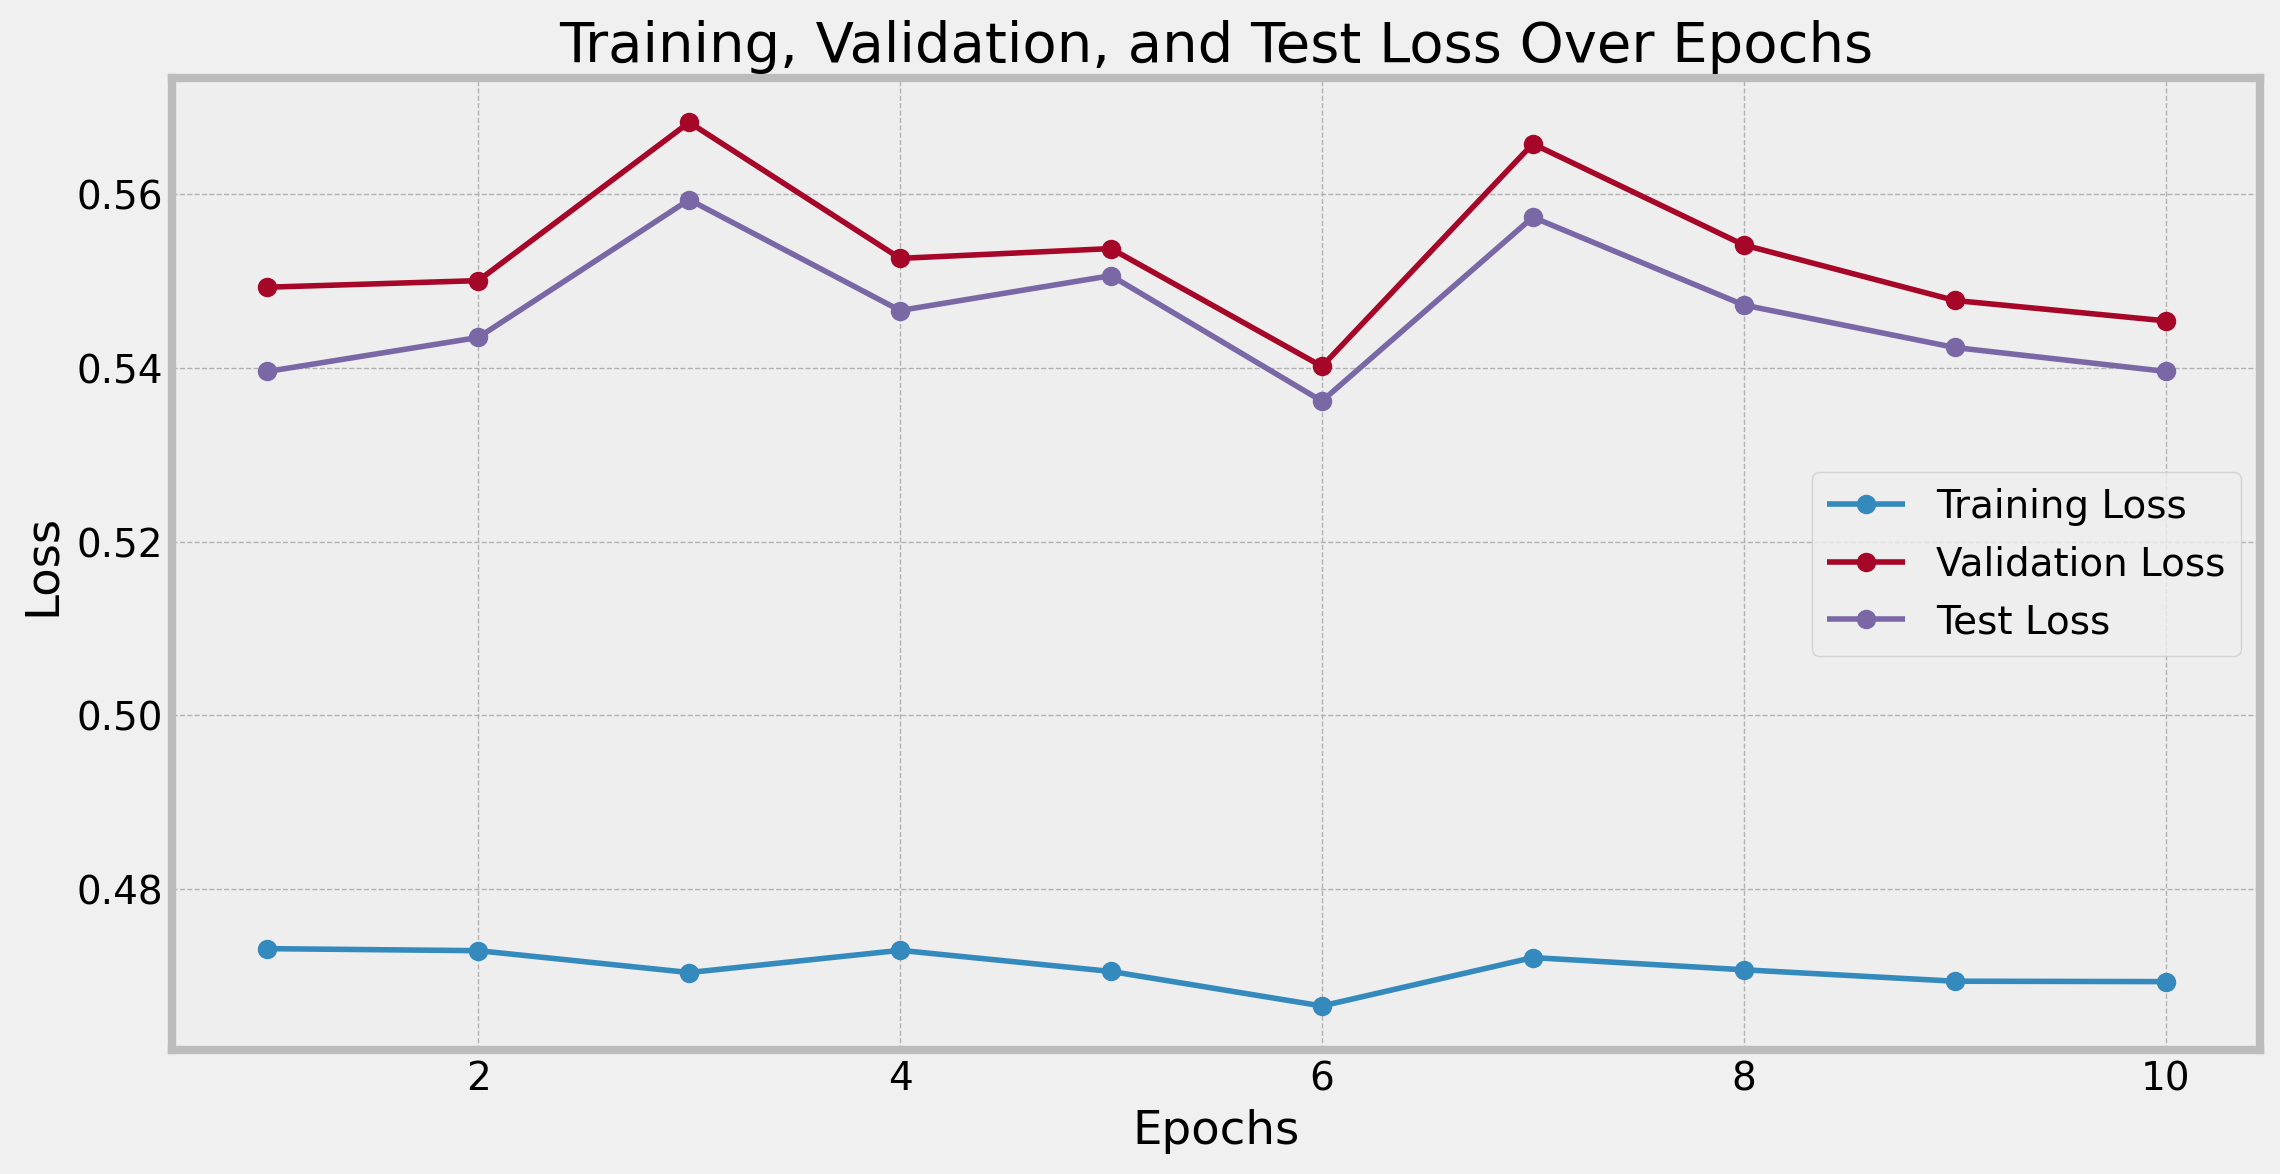

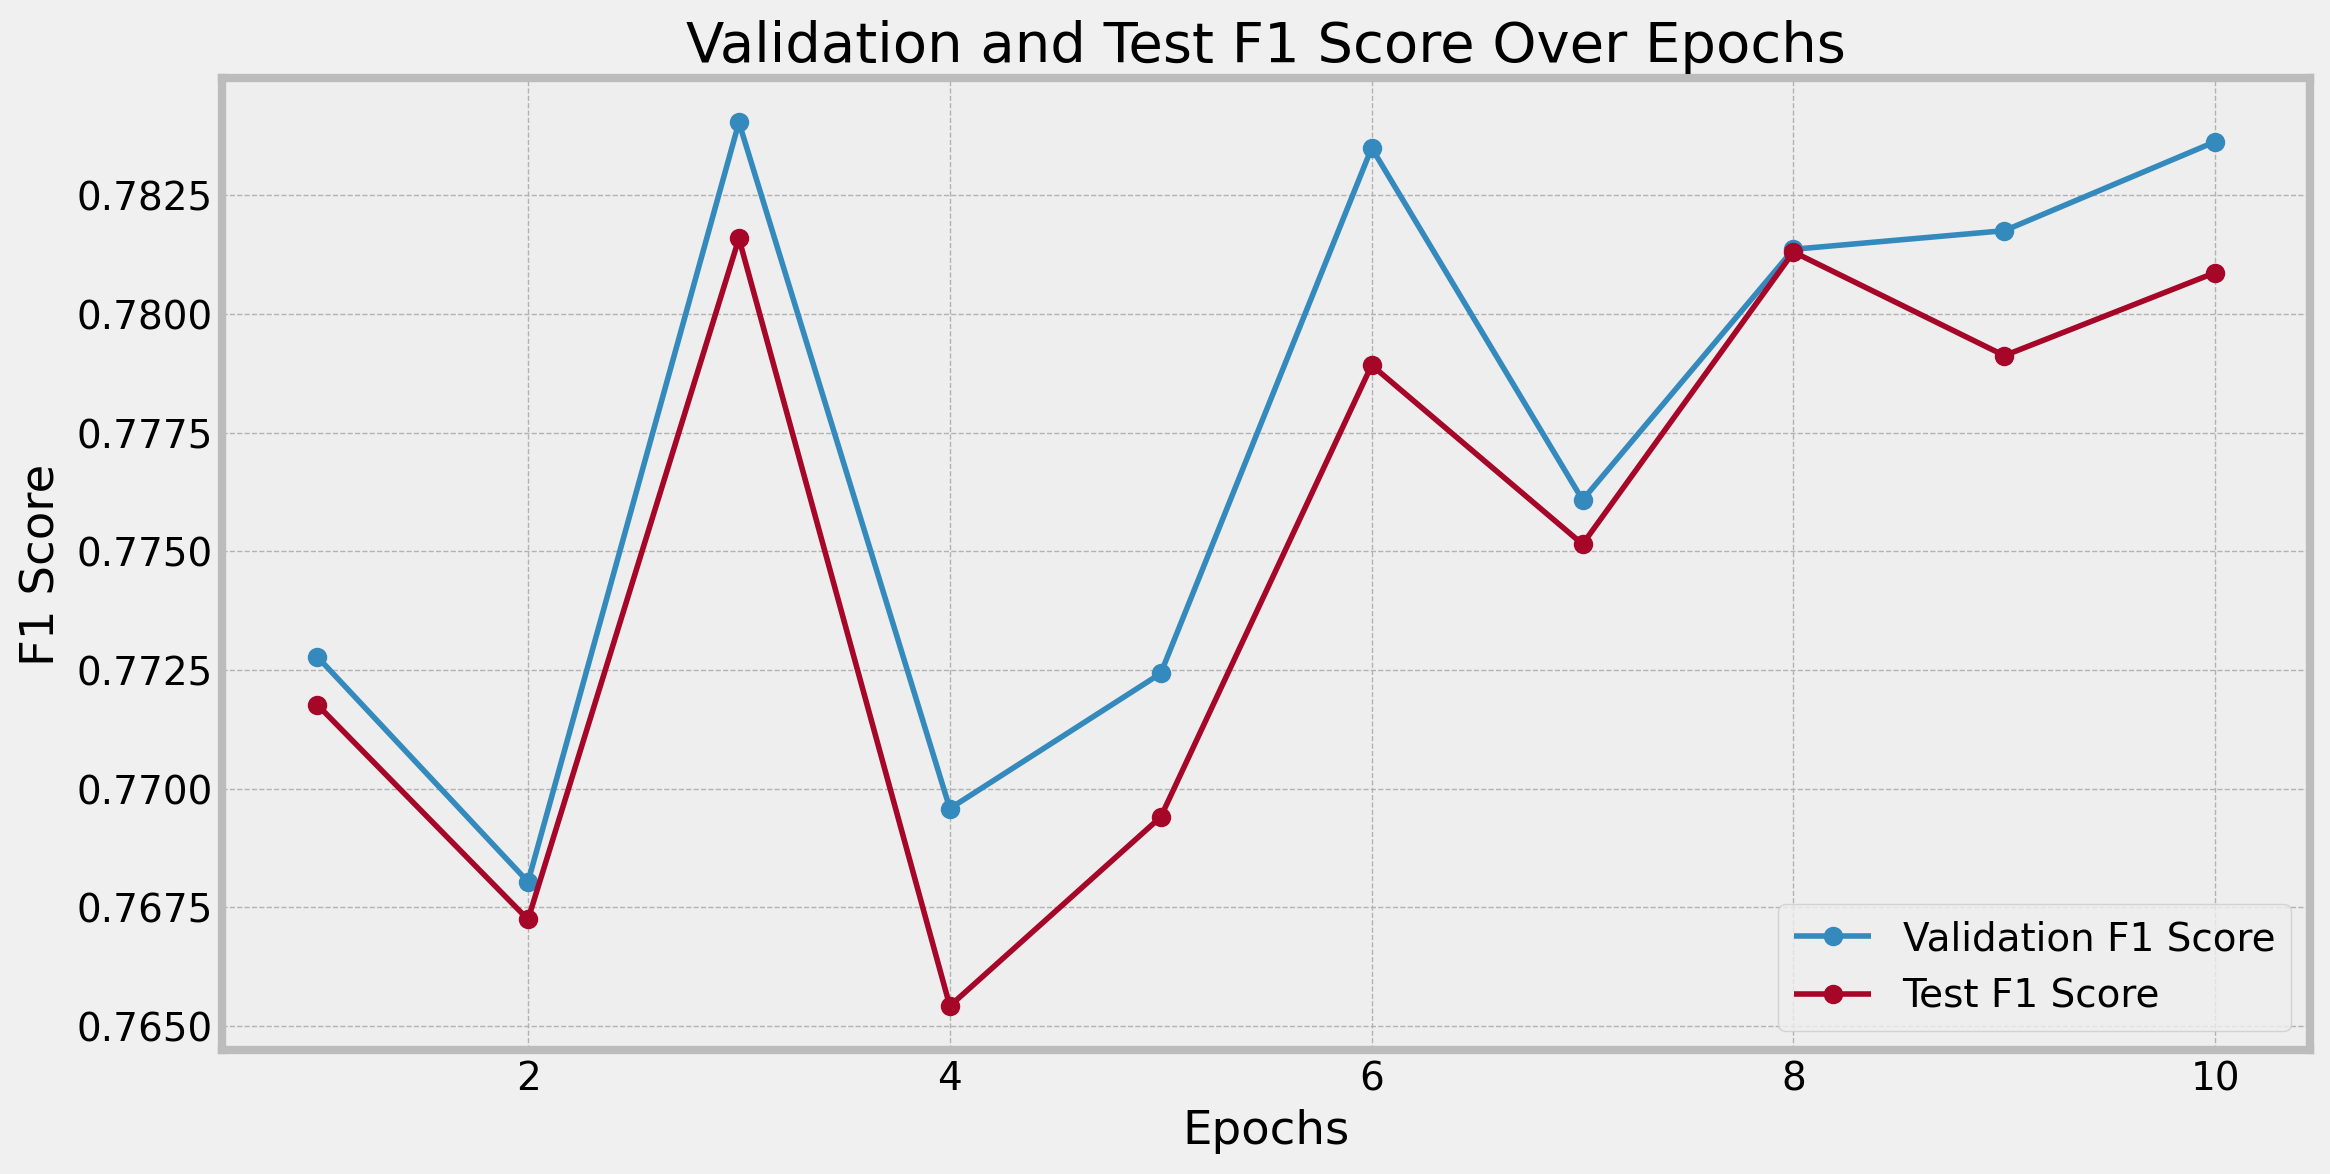

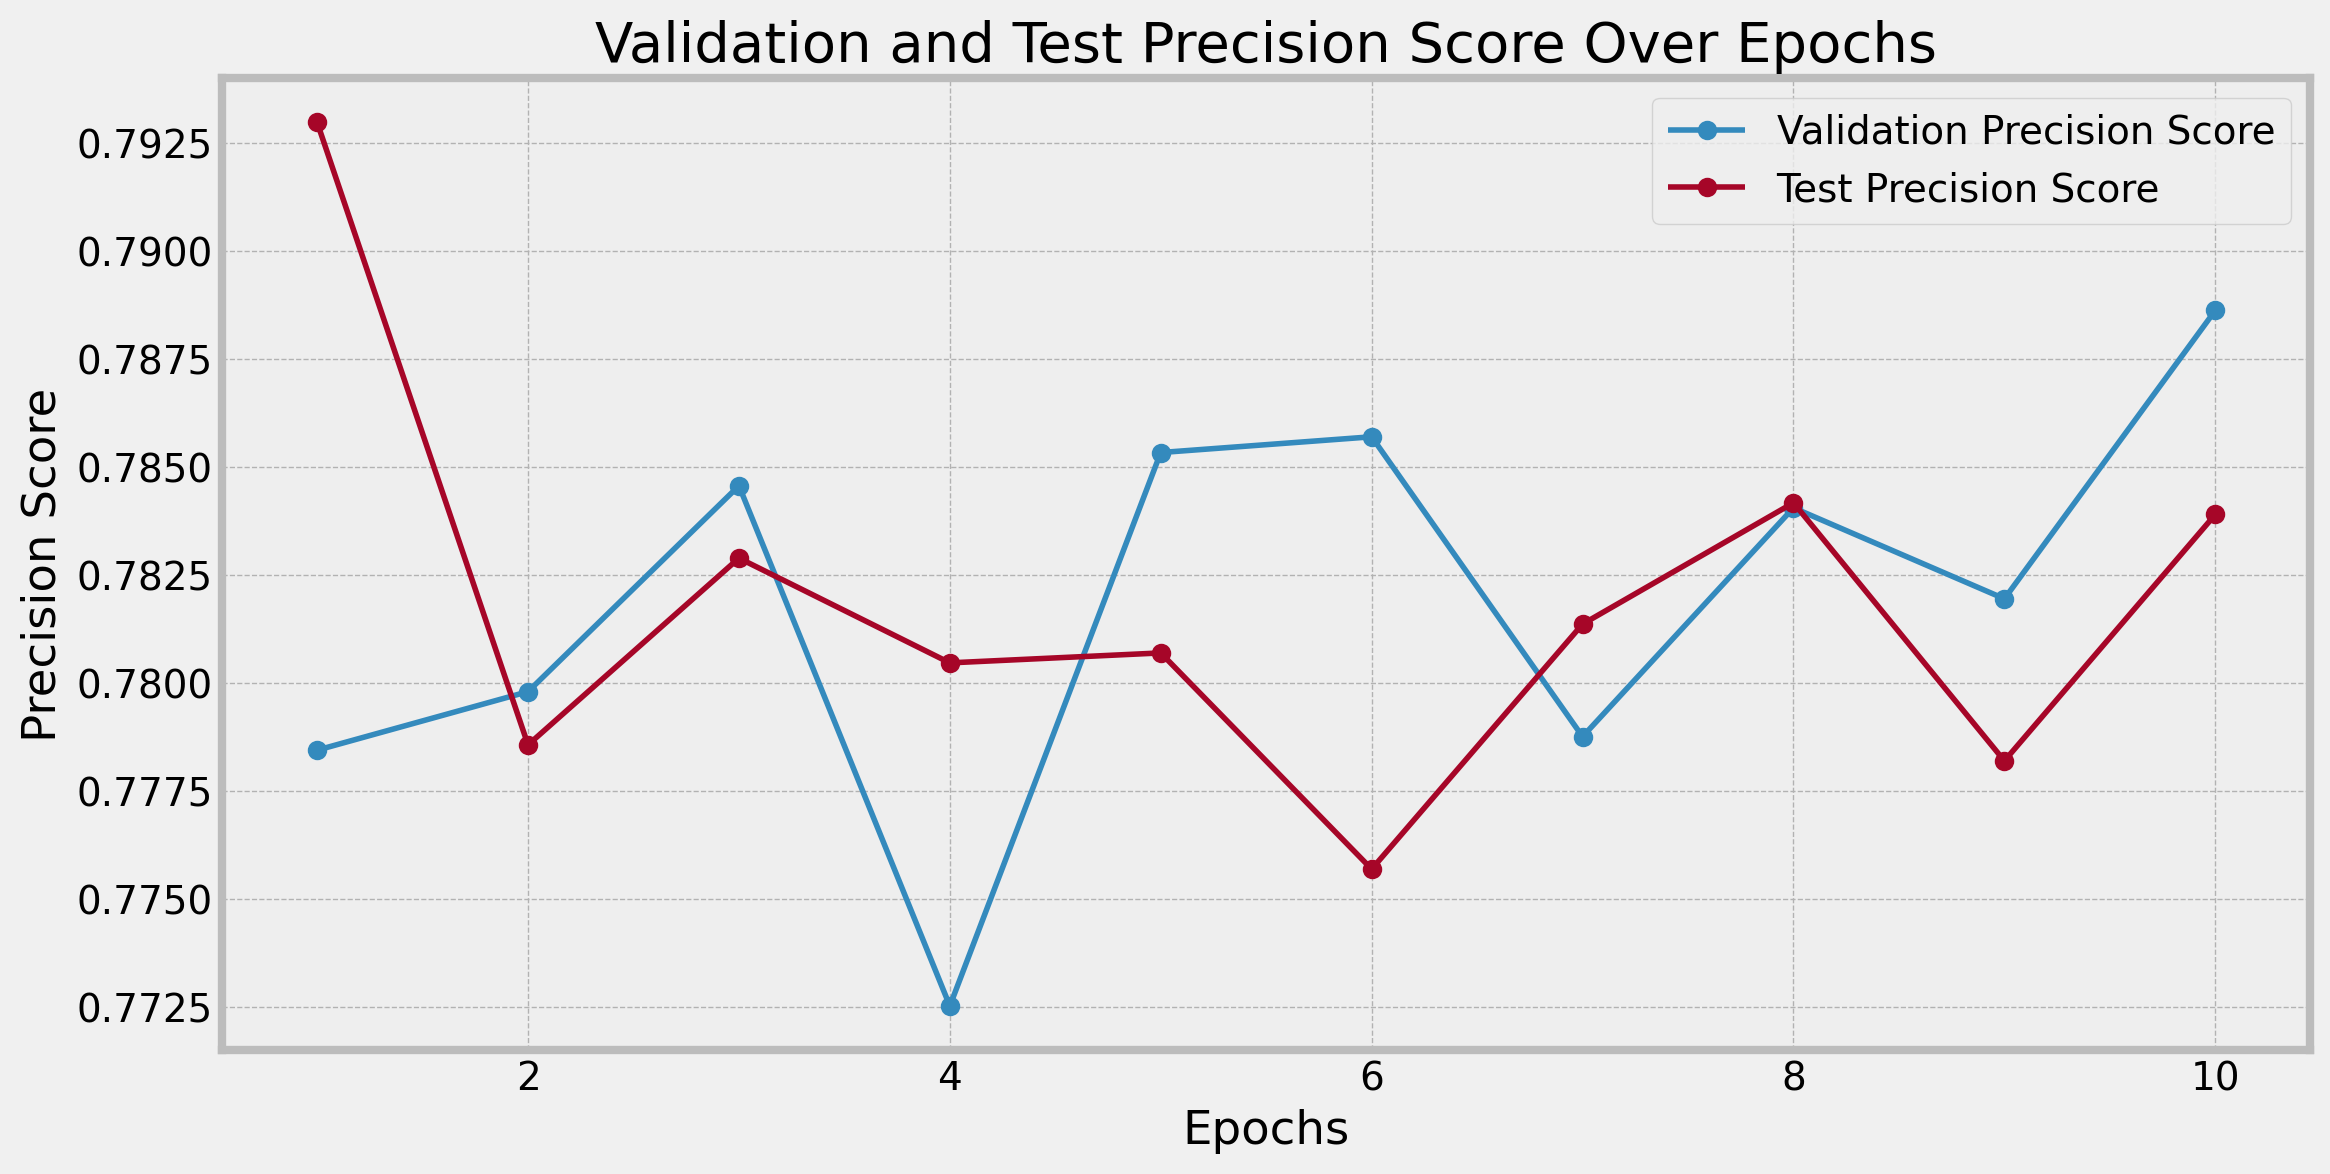

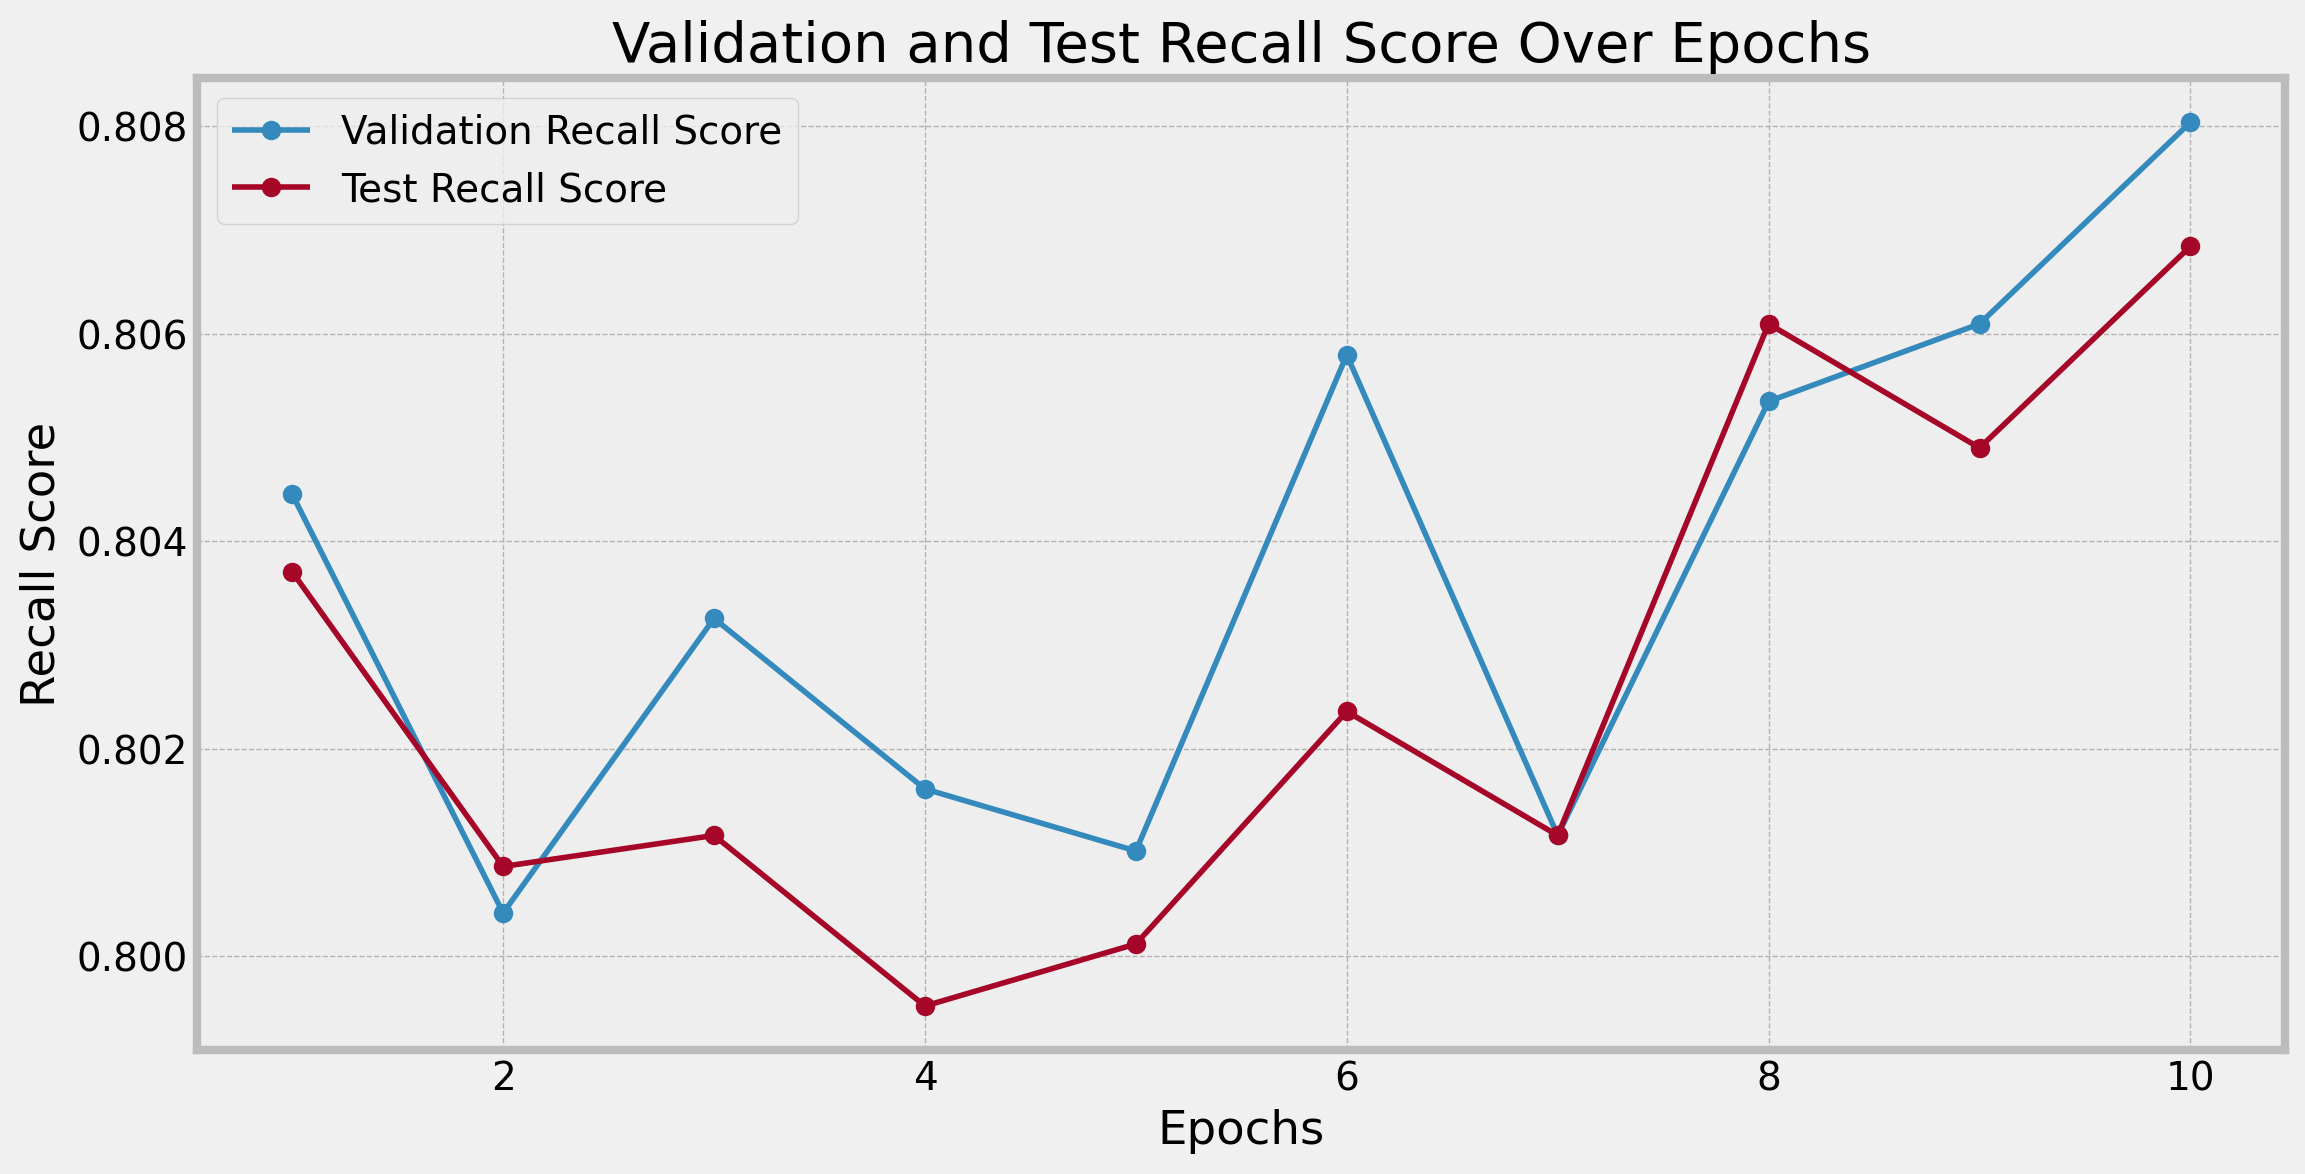

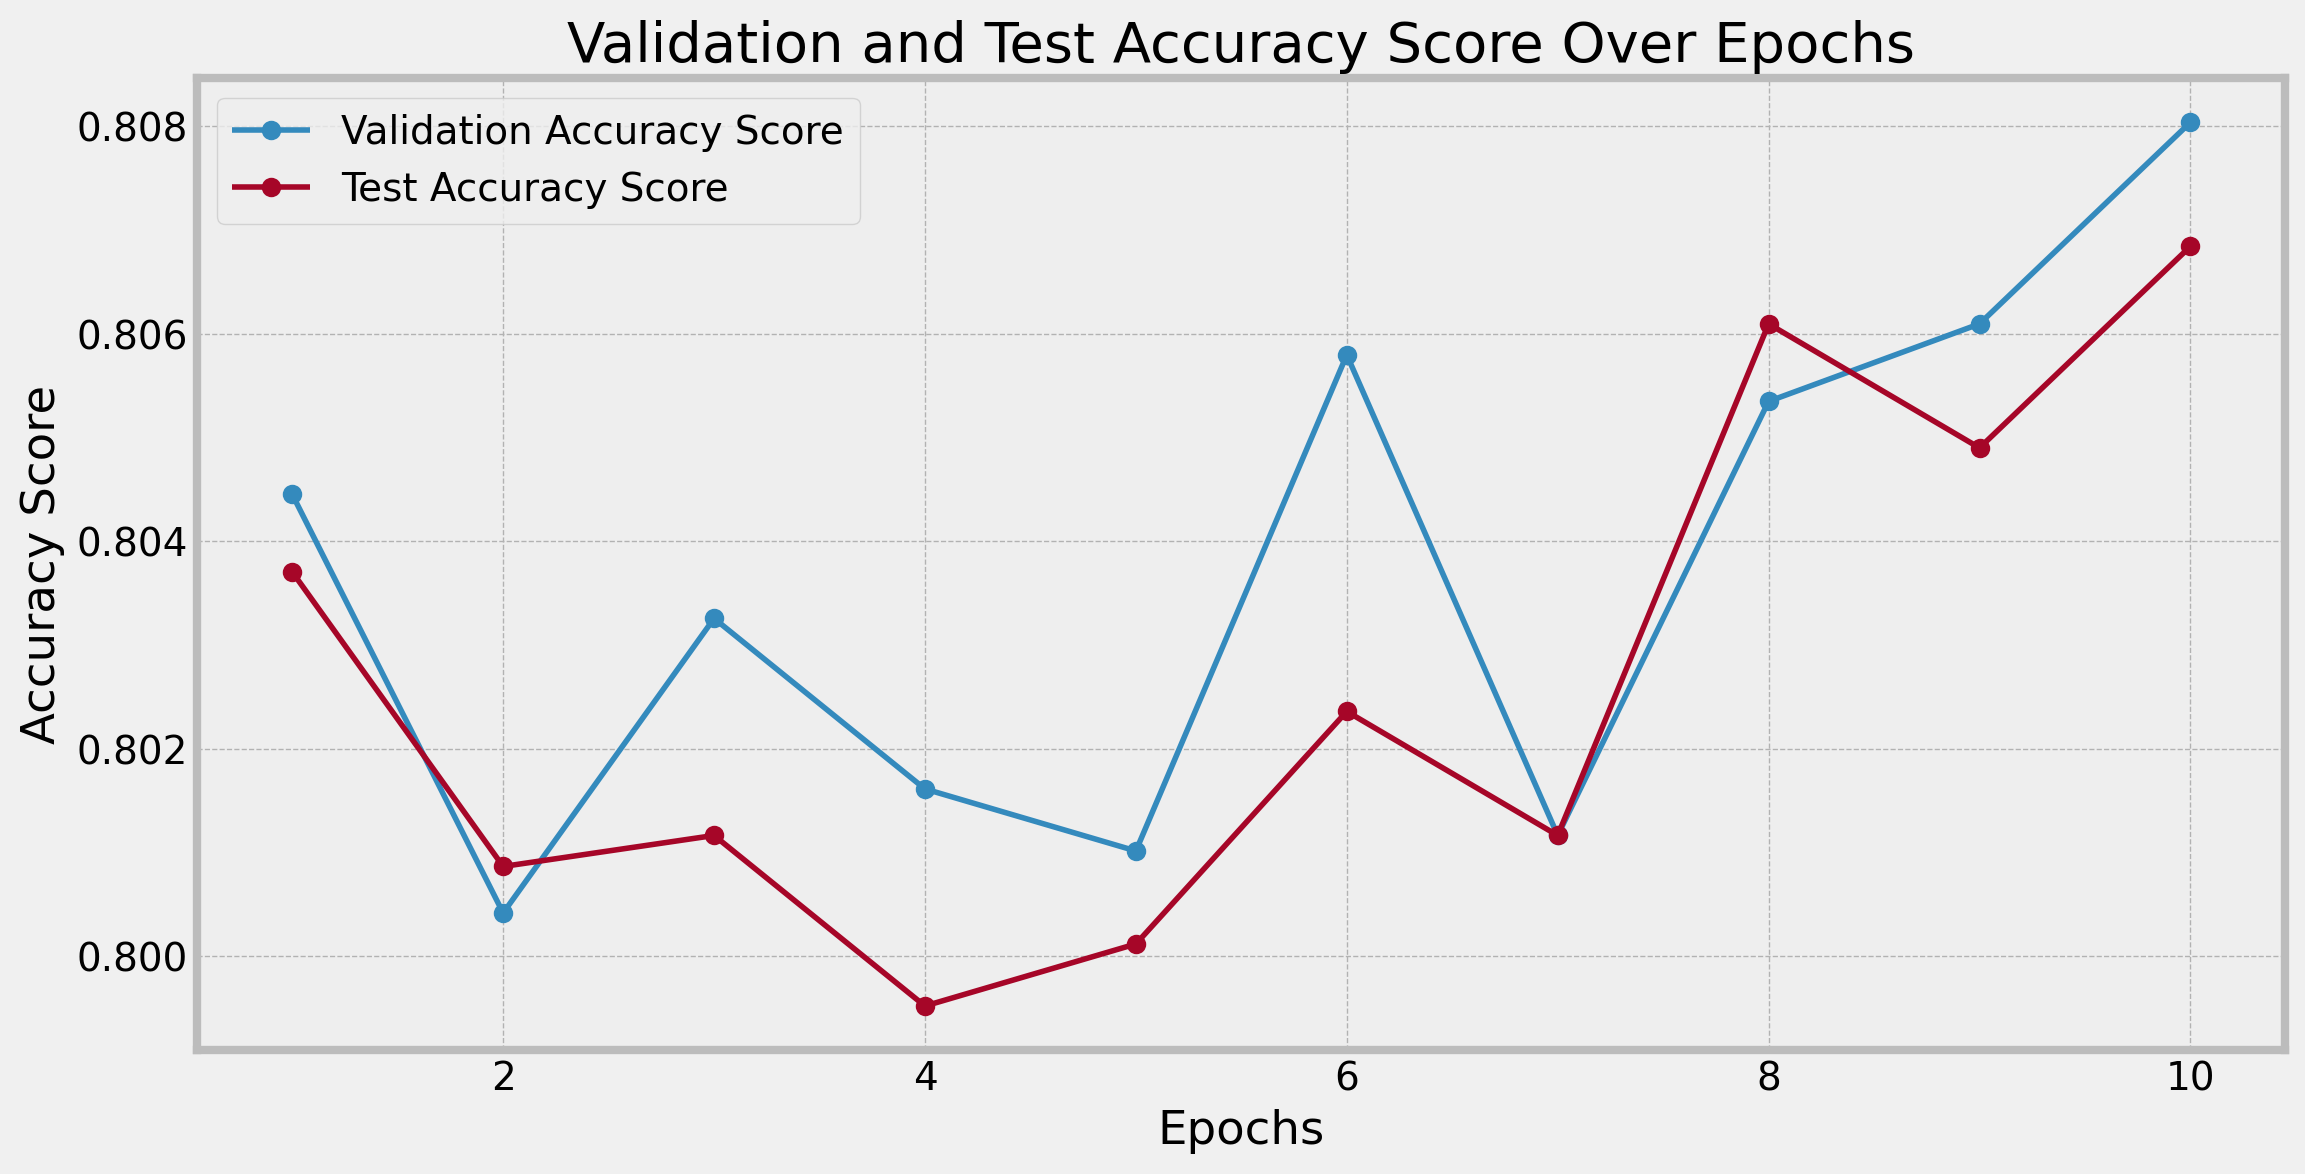

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Menggunakan range(1, num_epochs + 1) untuk sumbu x
epochs = range(1, num_epochs + 1)

# Plot training loss, validation loss, dan test loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.plot(epochs, test_losses, label='Test Loss', marker='o')
plt.title('Training, Validation, and Test Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot F1 Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_f1_scores, label='Validation F1 Score', marker='o')
plt.plot(epochs, test_f1_scores, label='Test F1 Score', marker='o')
plt.title('Validation and Test F1 Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Precision Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_precisions, label='Validation Precision Score', marker='o')
plt.plot(epochs, test_precisions, label='Test Precision Score', marker='o')
plt.title('Validation and Test Precision Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Recall Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_recalls, label='Validation Recall Score', marker='o')
plt.plot(epochs, test_recalls, label='Test Recall Score', marker='o')
plt.title('Validation and Test Recall Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall Score')
plt.legend()
plt.grid(True)
plt.show()

# Plot Accuracy Score pada validasi dan test
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracies, label='Validation Accuracy Score', marker='o')
plt.plot(epochs, test_accuracies, label='Test Accuracy Score', marker='o')
plt.title('Validation and Test Accuracy Score Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()


In [76]:
import pandas as pd

# Menggabungkan data dalam bentuk dictionary
data = {
    'Epoch': list(range(1, num_epochs + 1)),
    'Training Loss': train_losses,
    'Validation Loss': val_losses,
    'Test Loss': test_losses,
    'Validation F1 Score': val_f1_scores,
    'Validation Precision Score': val_precisions,
    'Validation Recall Score': val_recalls,
    'Validation Accuracy Score': val_accuracies,
    'Test F1 Score': test_f1_scores,
    'Test Precision Score': test_precisions,
    'Test Recall Score': test_recalls,
    'Test Accuracy Score': test_accuracies
}

# Buat DataFrame dari dictionary
df = pd.DataFrame(data)

# Tampilkan DataFrame
print(df)


   Epoch  Training Loss  Validation Loss  Test Loss  Validation F1 Score  \
0      1       0.473137         0.549276   0.539575             0.772781   
1      2       0.472903         0.550035   0.543494             0.768037   
2      3       0.470386         0.568255   0.559353             0.784033   
3      4       0.472944         0.552597   0.546595             0.769580   
4      5       0.470512         0.553724   0.550610             0.772427   
5      6       0.466536         0.540164   0.536164             0.783494   
6      7       0.472108         0.565781   0.557335             0.776080   
7      8       0.470704         0.554142   0.547230             0.781359   
8      9       0.469388         0.547755   0.542338             0.781751   
9     10       0.469342         0.545406   0.539587             0.783626   

   Validation Precision Score  Validation Recall Score  \
0                    0.778443                 0.804452   
1                    0.779797                 0

210/210 [==============================] - 2s 11ms/step


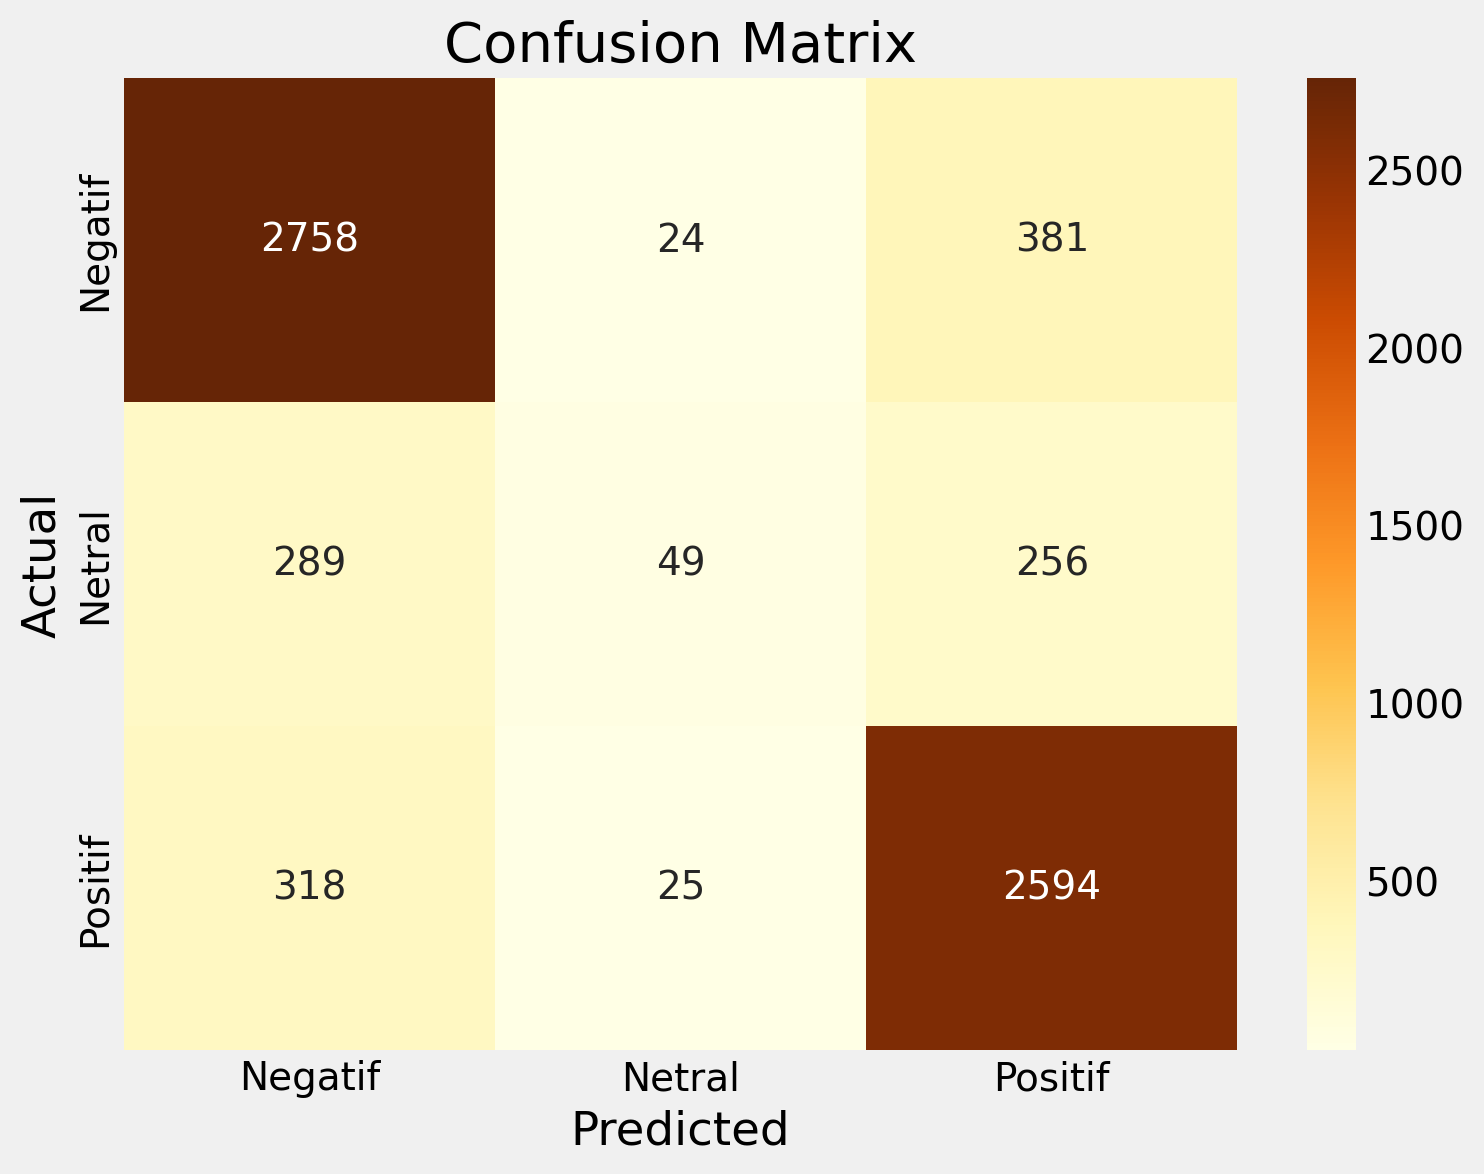

In [78]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluasi model pada data uji
test_loss, test_accuracy = model.evaluate(word_seq_test, test_labels, verbose=0)

# Membuat prediksi model pada data uji
test_predictions = model.predict(word_seq_test)
test_predictions = np.argmax(test_predictions, axis=1)

# Membuat confusion matrix
confusion = confusion_matrix(np.argmax(test_labels, axis=1), test_predictions)

# Daftar label kelas
class_labels = ["Negatif", "Netral", "Positif"]

# Membuat heatmap dari confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='YlOrBr', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
